# Сравнение моделей машинного обучения для прогнозирования ставки аукциона

In [9]:
import warnings
warnings.filterwarnings('ignore')

MIN_BUDGET = 250
LOWER_BID = 0.12
UPPER_BID = 4
KPI = ('roi', 'cpa')
KPI_VALUE = 3
MEMORY_FACTOR = 0.95

Для задачи прогнозирования и оптимизации BidAlgorithm использует Matlab  функции, которые работют как черный ящик. Для того, чтобы сравнение работы алгоритма и моделей машинного обучения было более точным мы использвали Matlab APi для Python, чтобы получить прогнозные значения ставок, как если бы мы запускали Sentic BidAlgorithm.

In [10]:
import pandas as pd
import numpy as np

bidAlgorithm_linear_constraid = pd.read_excel('bidAlgorithm_linear_constraid.xlsx')
train = pd.read_excel('bidAlgorithm_c_factors.xlsx')
train.columns = ['bid', 'cpc', 'q_score', 'exact', 'broad', 'phraze']
test = pd.read_excel('bidAlgorithm_pred_x.xlsx')
test.columns = ['predicted_bid', 'cpc', 'q_scire', 'exact', 'broad', 'phraze']
bid_algorithm_predicted_bid = test['predicted_bid']
test.drop(columns=['predicted_bid'], inplace=True)

# Данные

Перед началом использование моделей машинного обучения проведем анализ предоставленных данных.

In [11]:
pd.set_option('display.precision', 2)
data = pd.read_excel('test2csv.xlsx')
data.head()

,Date,Max CPC,Match Type,kw,Quality Score,Clicks,Impressions,Cost,Conversions,Revenue,datevalue
0,4/24/2019,1.17,1,40555006,0,0,0,0.00,0,0.0,43579
1,4/25/2019,1.17,1,40555006,7,2,27,1.68,0,0.0,43580
2,4/26/2019,1.17,1,40555006,8,0,45,0.00,0,0.0,43581
3,4/27/2019,1.17,1,40555006,8,0,34,0.00,0,0.0,43582
4,4/28/2019,1.17,1,40555006,8,0,22,0.00,0,0.0,43583


Комплексная инфомация о данных

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           5130 non-null   object 
 1   Max CPC        5130 non-null   float64
 2   Match Type     5130 non-null   int64  
 3   kw             5130 non-null   int64  
 4   Quality Score  5130 non-null   int64  
 5   Clicks         5130 non-null   int64  
 6   Impressions    5130 non-null   int64  
 7   Cost           5130 non-null   float64
 8   Conversions    5130 non-null   int64  
 9   Revenue        5130 non-null   float64
 10  datevalue      5130 non-null   int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 441.0+ KB


Для быстрого получения статистической информации о данных воспользуемся методом describe() в целях получения статистических характеристик для каждого числового признака (float и int типы): количество непропущенных значений, среднее значение, стандартное отклонение, значения минимума и максимума, а также 0.25, 0.5 и 0.75 квартили:

In [13]:
data.describe()

,Max CPC,Match Type,kw,Quality Score,Clicks,Impressions,Cost,Conversions,Revenue,datevalue
count,5130.00,5130.00,5.13e+03,5130.00,5130.00,5130.00,5130.00,5.13e+03,5130.00,5130.00
mean,2.78,1.95,4.07e+07,2.45,0.57,21.62,0.68,4.48e-03,1.84,43623.50
std,1.06,0.69,1.11e+05,3.18,2.34,58.61,3.29,6.97e-02,32.42,25.98
min,0.48,1.00,4.06e+07,0.00,0.00,0.00,0.00,0.00e+00,0.00,43579.00
25%,2.76,1.00,4.06e+07,0.00,0.00,0.00,0.00,0.00e+00,0.00,43601.00
50%,2.88,2.00,4.08e+07,0.00,0.00,0.00,0.00,0.00e+00,0.00,43623.50
75%,3.40,2.00,4.08e+07,6.00,0.00,9.00,0.00,0.00e+00,0.00,43646.00
max,4.00,3.00,4.08e+07,10.00,35.00,556.00,62.13,2.00e+00,1227.97,43668.00


Сгруппируем данные по номеру ключевого слова и расчитаем основные средние характеристики: показы, клики, стоимость, конверсия, доход.

In [14]:
columns = ['Clicks', 'Impressions', 'Cost', 'Conversions', 'Revenue']
kw_groups = data.groupby(['kw'])[columns].agg([np.mean, np.std, np.min, np.max])
kw_groups.head()

Clicks                 Impressions                    Cost        \
           mean   std amin amax        mean     std amin amax  mean   std   
kw                                                                          
40555006   0.79  1.20    0    5       19.43   13.83    0   55  0.54  0.89   
40555007   2.88  4.28    0   21       96.68  101.93    0  379  1.71  2.59   
40555008   0.00  0.00    0    0        0.00    0.00    0    0  0.00  0.00   
40555009   0.53  0.74    0    3       14.11    7.50    0   33  0.43  0.61   
40555010   1.77  2.09    0   10       61.88   28.49    0  137  1.14  1.40   

                     Conversions                 Revenue                      
         amin   amax        mean   std amin amax    mean    std amin    amax  
kw                                                                            
40555006  0.0   4.74        0.00  0.00    0    0    0.00   0.00  0.0    0.00  
40555007  0.0  12.72        0.02  0.15    0    1    8.88  59.38  0.0  428.99  
40555008  0.0   0.00        0.00  0.00    0    0    0.00   0.00  0.0    0.00  
40555009  0.0   2.98        0.00  0.00    0    0    0.00   0.00  0.0    0.00  
40555010  0.0   6.48        0.00  0.00    0    0    0.00   0.00  0.0    0.00

Для быстрого анализа полезно показать совместное распределение величин

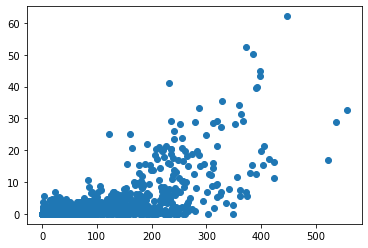

In [15]:
import matplotlib.pyplot as plt

plt.scatter(data['Impressions'], data['Cost'])

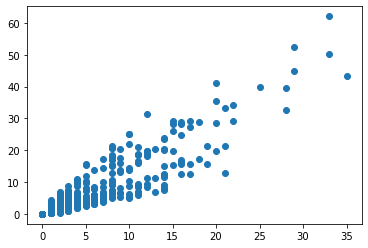

In [16]:
plt.scatter(data['Clicks'], data['Cost'])

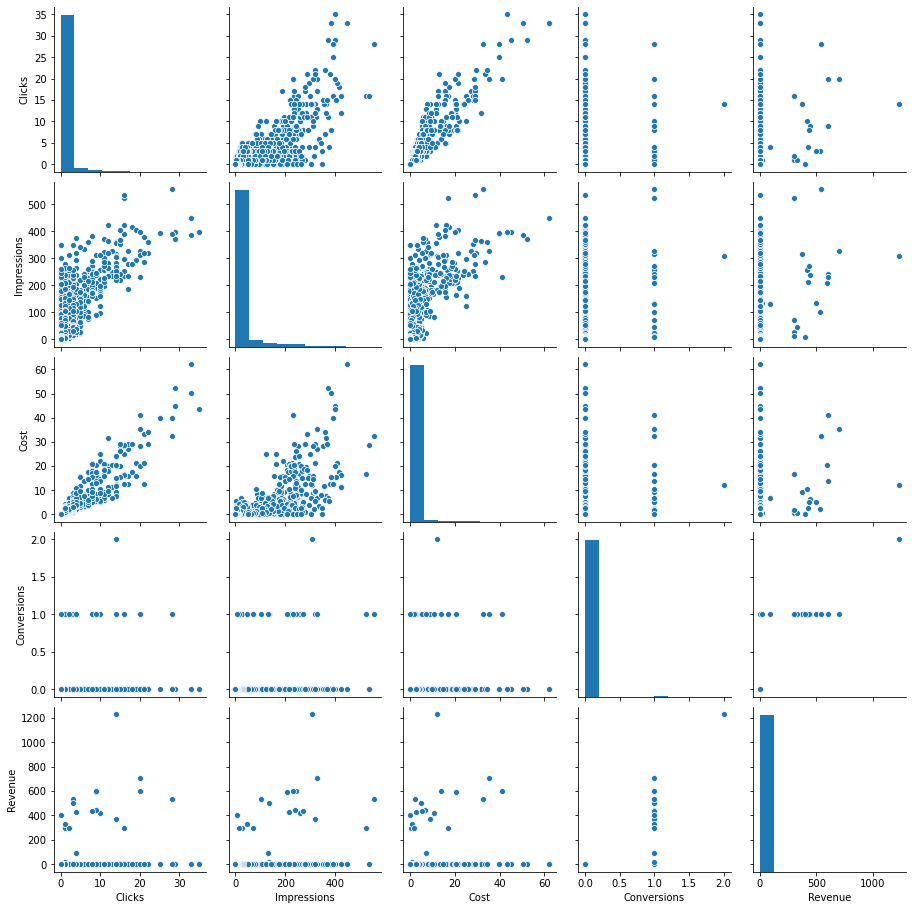

In [17]:
import seaborn as sns
features = ['Clicks', 'Impressions', 'Cost', 'Conversions', 'Revenue']
sns.pairplot(data[features]);

# Модели машинного обучения

In [19]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

x_train_len = round(train.shape[0]*0.75)
x_train = train[:x_train_len]
x_train.drop(columns=['bid'], inplace=True)
x_validation = train[x_train_len:]
x_validation.drop(columns=['bid'], inplace=True)
y_train = train['bid'][:x_train_len]
y_validation = train['bid'][x_train_len:]

class Models(object):
    
    global seed 
    seed = 34234
    
    # Initialization 
    def __init__(self, x_train, x_validation, y_train, y_validation):
        self.x_train = [x_train.iloc[i].tolist() for i in range(len(x_train))]
        self.x_validation = [x_validation.iloc[i].tolist() for i in range(len(x_validation))]
        self.y_train = y_train.tolist()
        self.y_validation = y_validation.tolist()
    
    
    @staticmethod
    def print_info(cross_val_scores, mse):
        print("Cross Validation Scores: ", cross_val_scores)
        print("Mean Squared Error: ", mse)
        
        
    # Linear Regression 
    def linear_regression(self, x_train, x_validation,  y_train, y_validation):
        reg = linear_model.LinearRegression()
        reg.fit(self.x_train, self.y_train)
        y_pred_list = reg.predict(self.x_validation)
        mse = mean_squared_error(self.y_validation, y_pred_list)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(reg, self.x_train, self.y_train, cv=kfold)
        print("\nLinear Regression Model")
        self.print_info(cross_val_scores, mse)
        return cross_val_scores, mse, y_pred_list
        
    # Random Forest Regression model 
    def random_forest(self, x_train, x_validation,  y_train, y_validation):
        rfr = RandomForestRegressor(n_estimators=8, max_depth=8, random_state=12, verbose=0)
        rfr.fit(self.x_train, self.y_train)
        y_pred_list = rfr.predict(self.x_validation)
        mse = mean_squared_error(self.y_validation, y_pred_list)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(rfr, self.x_train, self.y_train, cv=kfold)
        print("\nRandom Forest Regressor")
        self.print_info(cross_val_scores, mse)
        return cross_val_scores, mse, y_pred_list
            
    # Lasso method 
    def lasso(self, x_train, x_validation,  y_train, y_validation):
        reg = linear_model.Lasso(alpha = 0.1)
        reg.fit(self.x_train, self.y_train)
        y_pred_list = reg.predict(self.x_validation)
        mse = mean_squared_error(self.y_validation, y_pred_list)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(reg, self.x_train, self.y_train, cv=kfold)
        print("\nLasso Regression Model")
        self.print_info(cross_val_scores, mse)
        return cross_val_scores, mse, y_pred_list
    
    # Gradient Boosing Regressor
    def GBR(self, x_train, x_validation,  y_train, y_validation):
        gbr = GradientBoostingRegressor(n_estimators=175, learning_rate=0.08, max_depth=3, random_state=1232, loss='ls')
        gbr.fit(self.x_train, self.y_train)
        y_pred_list = gbr.predict(self.x_validation)
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cross_val_scores = cross_val_score(gbr, self.x_train, self.y_train, cv=kfold)
        mse = mean_squared_error(self.y_validation, gbr.predict(self.x_validation))
        print('\nGradient Boosting Regressor')
        self.print_info(cross_val_scores, mse)
        return cross_val_scores, mse, y_pred_list

parameters = {
    'n_estimators' : [170, 175, 180],
    'learning_rate' : [0.075, 0.08, 0.1],
    'max_depth' : [2, 3, 4]
}

gbr = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, max_depth=5, random_state=232, loss='ls')
gs_cv = GridSearchCV(gbr, parameters).fit(x_train, y_train)

from types import FunctionType

methods = [x for x, y in Models.__dict__.items() if type(y) == FunctionType]
methods.remove('__init__')
cross_scores_list, mse_list = [], []
bid_predicted = []
for model in methods:
    reg = Models(x_train, x_validation, y_train, y_validation)
    cross_val_scores, mse, y_pred_list = getattr(reg, model)(x_train, x_validation, y_train, y_validation)
    cross_scores_list.append(cross_val_scores)
    mse_list.append(mse)
    bid_predicted.append(y_pred_list)


Linear Regression Model
Cross Validation Scores:  [0.78285101 0.71290593 0.57803353 0.67617059 0.71183978 0.70570387
 0.53489761 0.7366445  0.73105241 0.7664393 ]
Mean Squared Error:  1.1288127112321396

Random Forest Regressor
Cross Validation Scores:  [0.87146775 0.77795829 0.56034852 0.80209991 0.81071763 0.77886803
 0.74181807 0.83621321 0.67548226 0.81389499]
Mean Squared Error:  1.1639548067394374

Lasso Regression Model
Cross Validation Scores:  [0.76591591 0.67842704 0.59165045 0.66389751 0.66925138 0.66733912
 0.55251042 0.68455627 0.67907489 0.68526235]
Mean Squared Error:  0.8719170684864471

Gradient Boosting Regressor
Cross Validation Scores:  [0.85734586 0.78244776 0.61712423 0.83620166 0.86110431 0.82292654
 0.71746843 0.84641054 0.63304237 0.84600295]
Mean Squared Error:  1.1660915271258596


Lasso Regression иммет самую низкую среднеквадратическую ошибку.

In [20]:
lasso_reg = linear_model.Lasso(alpha = 0.1)
lasso_reg.fit(x_train, y_train)
y_pred_list = lasso_reg.predict(test)

In [21]:
print('BidAlgorithm values:', sum(bid_algorithm_predicted_bid))
print('LassoRegression values:', sum(y_pred_list))

BidAlgorithm values: 206.28763664524854
LassoRegression values: 222.74511981488754


По сумме ставок видно, что значения ставок смоделированные Lasso Regression имеют больше шансов на успех за счет более высокого значения.
Для сравнения результатов прогнозирования ставки смроделируем значения ставок с помощью cpc2bid скрипта BidAlgorithm и сравним их с прогнозными значениями Lasso Regression.

In [25]:
lassoVsRidge_data = pd.read_excel('LassoVsCpc2Bid.xlsx')
x_train_len = round(lassoVsRidge_data.shape[0]*0.75)
x_train = lassoVsRidge_data[:x_train_len]
x_train.drop(columns=['bid'], inplace=True)
x_validation = lassoVsRidge_data[x_train_len:]
x_validation.drop(columns=['bid'], inplace=True)
y_train = lassoVsRidge_data['bid'][:x_train_len]
y_validation = lassoVsRidge_data['bid'][x_train_len:]

bidAlgoData = pd.read_excel('predicted_data.xlsx')

y_pred_list = lasso_reg.predict(x_validation)
y_true = bidAlgoData['true']
bid = bidAlgoData['pred']

MSEbid = mean_squared_error(bid, y_true)
MSElass = mean_squared_error(y_pred_list, y_true)
print('MSE BidAlgorithm: ', MSEbid)
print('MSE LassoRegression: ', MSElass)

MSE BidAlgorithm:  0.8615281364369777
MSE LassoRegression:  0.5312177797594912


Более низкая оценка MSE свидетельствует о том, что алгоритм Lasso Regression лучше справился с прогнозированием значений.